In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

**Data** **preprocessing**

In [4]:
Bloomsbury=pd.read_csv('/content/Bloomsbury.csv')
Eltham=pd.read_csv('/content/Eltham.csv')
Harlington=pd.read_csv('/content/Harlington.csv')
Marylebone_Road=pd.read_csv('/content/Marylebone_Road.csv')
N_Kensington=pd.read_csv('/content/N_Kensington.csv')

In [5]:
sites_name=['Bloomsbury','Eltham','Harlington','Marylebone_Road','N_Kensington']
air_pollutants_list=['nox','no2','no','o3', 'pm2.5','ws','wd','air_temp']

sites_dic={'Bloomsbury':Bloomsbury,
               'Eltham':Eltham,
                'Harlington':Harlington,
                'Marylebone_Road':Marylebone_Road,
                'N_Kensington':N_Kensington
               }


In [6]:
for key, df in sites_dic.items():
    print(f"Dataset: {key}")
    for col in df.columns:
        null_count = df[col].isnull().sum()
        null_percent = (null_count / len(df)) * 100
        print(f"{col}: {null_count} nulls ({null_percent:.2f}%)")
    print('----------------------')

Dataset: Bloomsbury
site: 0 nulls (0.00%)
code: 0 nulls (0.00%)
date: 0 nulls (0.00%)
nox: 308 nulls (1.76%)
no2: 308 nulls (1.76%)
no: 307 nulls (1.75%)
o3: 348 nulls (1.99%)
so2: 3742 nulls (21.36%)
pm10: 1779 nulls (10.15%)
pm2.5: 860 nulls (4.91%)
v10: 1779 nulls (10.15%)
v2.5: 860 nulls (4.91%)
nv10: 1779 nulls (10.15%)
nv2.5: 860 nulls (4.91%)
ws: 576 nulls (3.29%)
wd: 576 nulls (3.29%)
air_temp: 576 nulls (3.29%)
----------------------
Dataset: Eltham
site: 0 nulls (0.00%)
code: 0 nulls (0.00%)
date: 0 nulls (0.00%)
nox: 595 nulls (3.40%)
no2: 595 nulls (3.40%)
no: 595 nulls (3.40%)
o3: 65 nulls (0.37%)
pm2.5: 1743 nulls (9.95%)
v2.5: 1740 nulls (9.93%)
nv2.5: 1743 nulls (9.95%)
ws: 576 nulls (3.29%)
wd: 576 nulls (3.29%)
air_temp: 576 nulls (3.29%)
----------------------
Dataset: Harlington
site: 0 nulls (0.00%)
code: 0 nulls (0.00%)
date: 0 nulls (0.00%)
nox: 753 nulls (4.30%)
no2: 753 nulls (4.30%)
no: 753 nulls (4.30%)
o3: 471 nulls (2.69%)
pm10: 537 nulls (3.07%)
pm2.5: 537

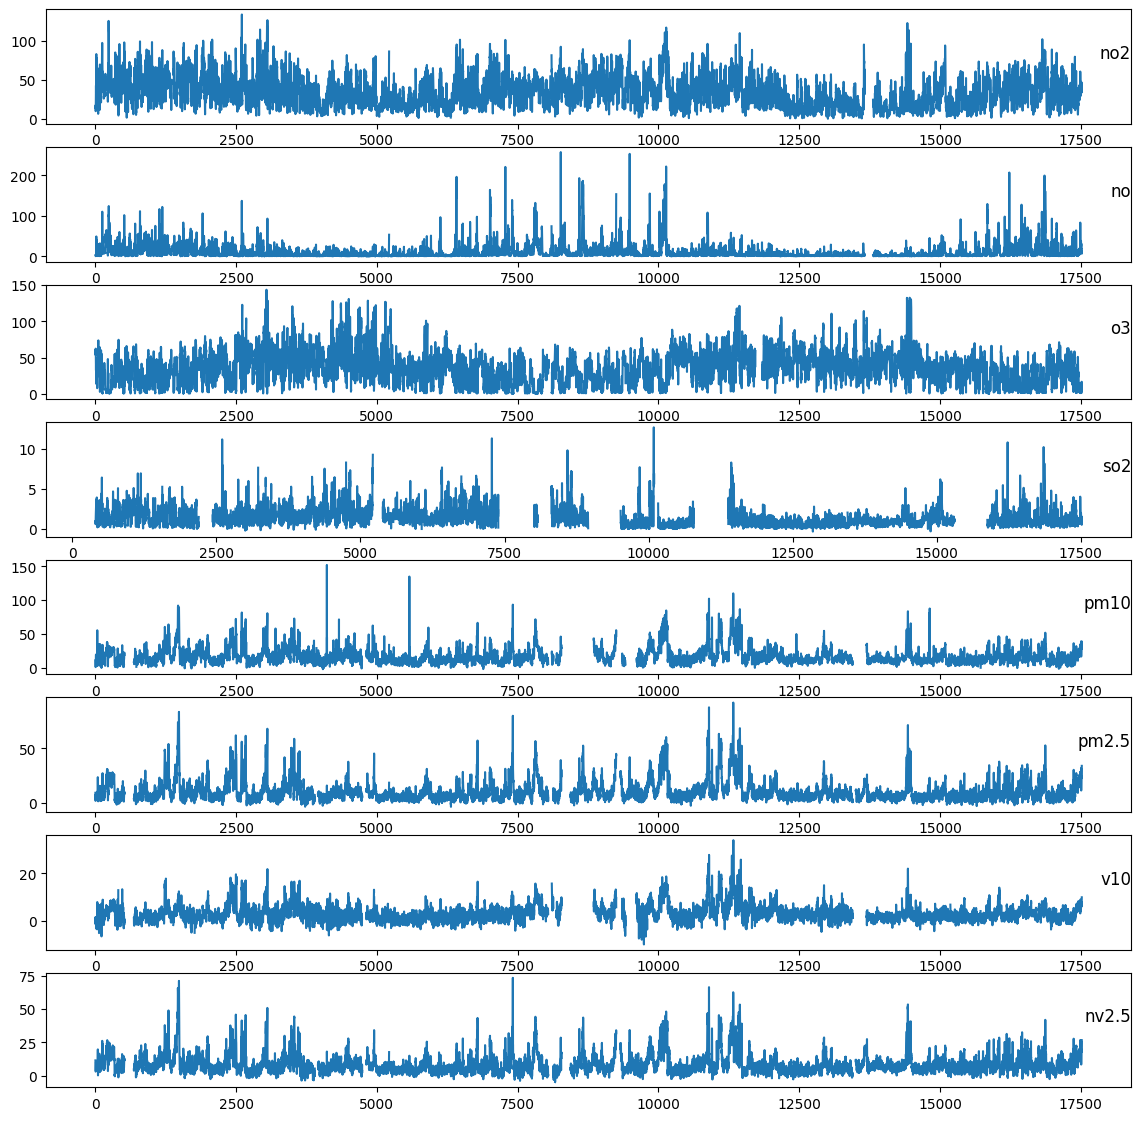

In [7]:
def show_graph(site):
  dataset=sites_dic[site]
  values = dataset.values

  columns = [4, 5, 6, 7, 8, 9, 10, 13]

  pyplot.figure(figsize=(14,14))
  i=1
  for column in columns:
      pyplot.subplot(len(columns), 1, i)
      pyplot.plot(values[:, column])
      pyplot.title(dataset.columns[column], y=0.5, loc='right')
      i += 1
  pyplot.show()

show_graph('Bloomsbury')

Data Filling
For data filling, we primarily used the IDW (Inverse Distance Weighting) method and linear interpolation, as described in the paper ST-MVL: Filling Missing Values in Geo-sensory Time Series Data.

IDW: Because IDW requires spatial coordinate information, we first need to store the latitude and longitude values for each monitoring station.

In [8]:
coordinate_dic={'Bloomsbury':[51.52229,-0.125889],
               'Eltham':[51.45258,0.070766],
                'Harlington':[51.48879,-0.441614],
                'Marylebone_Road':[51.52253,-0.154611],
                'N_Kensington':[51.52105,-0.213492]
               }

In [9]:
## Data has been stored in copies
import copy
Bloomsbury_copy=copy.deepcopy(Bloomsbury)
Eltham_copy=copy.deepcopy(Eltham)
Harlington_copy=copy.deepcopy(Harlington)
Marylebone_Road_copy=copy.deepcopy(Marylebone_Road)
N_Kensington_copy=copy.deepcopy(N_Kensington)

copy_dic={'Bloomsbury':Bloomsbury_copy,
               'Eltham':Eltham_copy,
                'Harlington':Harlington_copy,
                'Marylebone_Road':Marylebone_Road_copy,
                'N_Kensington':N_Kensington_copy
               }

In [10]:
## Function for null values removal
import math
def interpolation(lon, lat, lst,P=2):
    """
    :param lon: The x value of the point to be interpolated
    :param lat: The y value of the point to be interpolated
    :param lst: lst is an array of existing data, with the structure: [[x1, y1, z1], [x2, y2, z2], ...]
    :return: The return value is the value of the interpolated point
    """
    p0 = [lon, lat]
    sum0 = 0
    sum1 = 0
    temp = []
    # Traverse to get the distance between this point and all sampling
    for point in lst:
        if lon == point[0] and lat == point[1]:
            return point[2]
        Di = distance(p0, point)
        # Create a new object, otherwise the original value of lst will be
        ptn = copy.deepcopy(point)
        ptn.append(Di)
        temp.append(ptn)

    # Sort from small to large according to the value of ptn.append() above
    temp1 = sorted(temp, key=lambda point: point[3])
    # Traverse the first 15 points in the sort and calculate sum0 and sum1 according to the formula
    for point in temp1[0:]:
        sum0 += point[2] / math.pow(point[3], P)
        sum1 += 1 / math.pow(point[3], P)

    return sum0 / sum1

# Calculate the distance between two points
def distance(p, pi):
    dis = (p[0] - pi[0]) * (p[0] - pi[0]) + (p[1] - pi[1]) * (p[1] - pi[1])
    m_result = math.sqrt(dis)
    return m_result


In [11]:
def fullfill_missing(site):
    ls_temp=copy.deepcopy(sites_name)
    ls_temp.remove(site)

    for i in sites_dic[site].index.tolist():
        for j in air_pollutants_list:
            if(np.isnan(sites_dic[site].iloc[i][j])):
                ls_temp2=[]
                for m in ls_temp:
                    if(not np.isnan(sites_dic[m].iloc[i][j])):
                        temp_value=copy.deepcopy(coordinate_dic[m])
                        temp_value.append(sites_dic[m].iloc[i][j])
                        ls_temp2.append(temp_value)
                if(len(ls_temp2)!=0):
                    copy_dic[site].loc[i,j]=interpolation(coordinate_dic[site][0],coordinate_dic[site][1],ls_temp2)

In [12]:
fullfill_missing('Bloomsbury')
fullfill_missing('Eltham')
fullfill_missing('Harlington')
fullfill_missing('Marylebone_Road')
fullfill_missing('N_Kensington')

In [13]:
for i in sites_name:
    print(i,':')
    for pollutant in air_pollutants_list:
        null_counts = copy_dic[i][pollutant].isnull().value_counts()
        if len(null_counts) > 1:
            print(pollutant, 'null values:', null_counts.values[1])
        else:
            print(pollutant, 'null values:', 0)
    print('----------------------')

Bloomsbury :
nox null values: 0
no2 null values: 0
no null values: 0
o3 null values: 0
pm2.5 null values: 0
ws null values: 576
wd null values: 576
air_temp null values: 576
----------------------
Eltham :
nox null values: 0
no2 null values: 0
no null values: 0
o3 null values: 0
pm2.5 null values: 0
ws null values: 576
wd null values: 576
air_temp null values: 576
----------------------
Harlington :
nox null values: 0
no2 null values: 0
no null values: 0
o3 null values: 0
pm2.5 null values: 0
ws null values: 576
wd null values: 576
air_temp null values: 576
----------------------
Marylebone_Road :
nox null values: 0
no2 null values: 0
no null values: 0
o3 null values: 0
pm2.5 null values: 0
ws null values: 576
wd null values: 576
air_temp null values: 576
----------------------
N_Kensington :
nox null values: 0
no2 null values: 0
no null values: 0
o3 null values: 0
pm2.5 null values: 0
ws null values: 576
wd null values: 576
air_temp null values: 576
----------------------


In [14]:
## filling NaN values by linear interpolation
for i in sites_name:
    copy_dic[i]=copy_dic[i].interpolate(method='linear', axis=0)

/tmp/ipython-input-178426746.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  copy_dic[i]=copy_dic[i].interpolate(method='linear', axis=0)
/tmp/ipython-input-178426746.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  copy_dic[i]=copy_dic[i].interpolate(method='linear', axis=0)
/tmp/ipython-input-178426746.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  copy_dic[i]=copy_dic[i].interpolate(method='linear', axis=0)
/tmp/ipython-input-178426746.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating 

The red dots represent our infill values. You can see that some of the infill values aren't very good. This is primarily due to the small number of samples used in the IDW algorithm, specifically the small number of monitoring stations. This is also due to the influence of significant noise. To reduce the impact of noise on subsequent training, we need to process the dataset using a filter.

In [15]:
empty=[[],[],[],[],[],[],[],[]]
for i in range(len(air_pollutants_list)):
    em=Bloomsbury[air_pollutants_list[i]]
    ls=em[np.isnan(em)].index.tolist()
    empty[i]=ls

def show_graph2(site):
  dataset=sites_dic[site]
  dataset2=copy_dic[site]

  air_pollutants_list=['nox','no2','no','o3','pm2.5','ws','wd','air_temp']

  # plot each column
  pyplot.figure(figsize=(14,14))
  i=1
  for column in air_pollutants_list:
      pyplot.subplot(len(air_pollutants_list), 1, i)
      pyplot.plot(dataset.loc[:, column].values,linewidth=0.5)
      pyplot.title(column, y=0.5, loc='right')
      pyplot.scatter(empty[i-1],dataset2.loc[empty[i-1], column].values,color='red',s=0.4)
      i += 1

  pyplot.show()

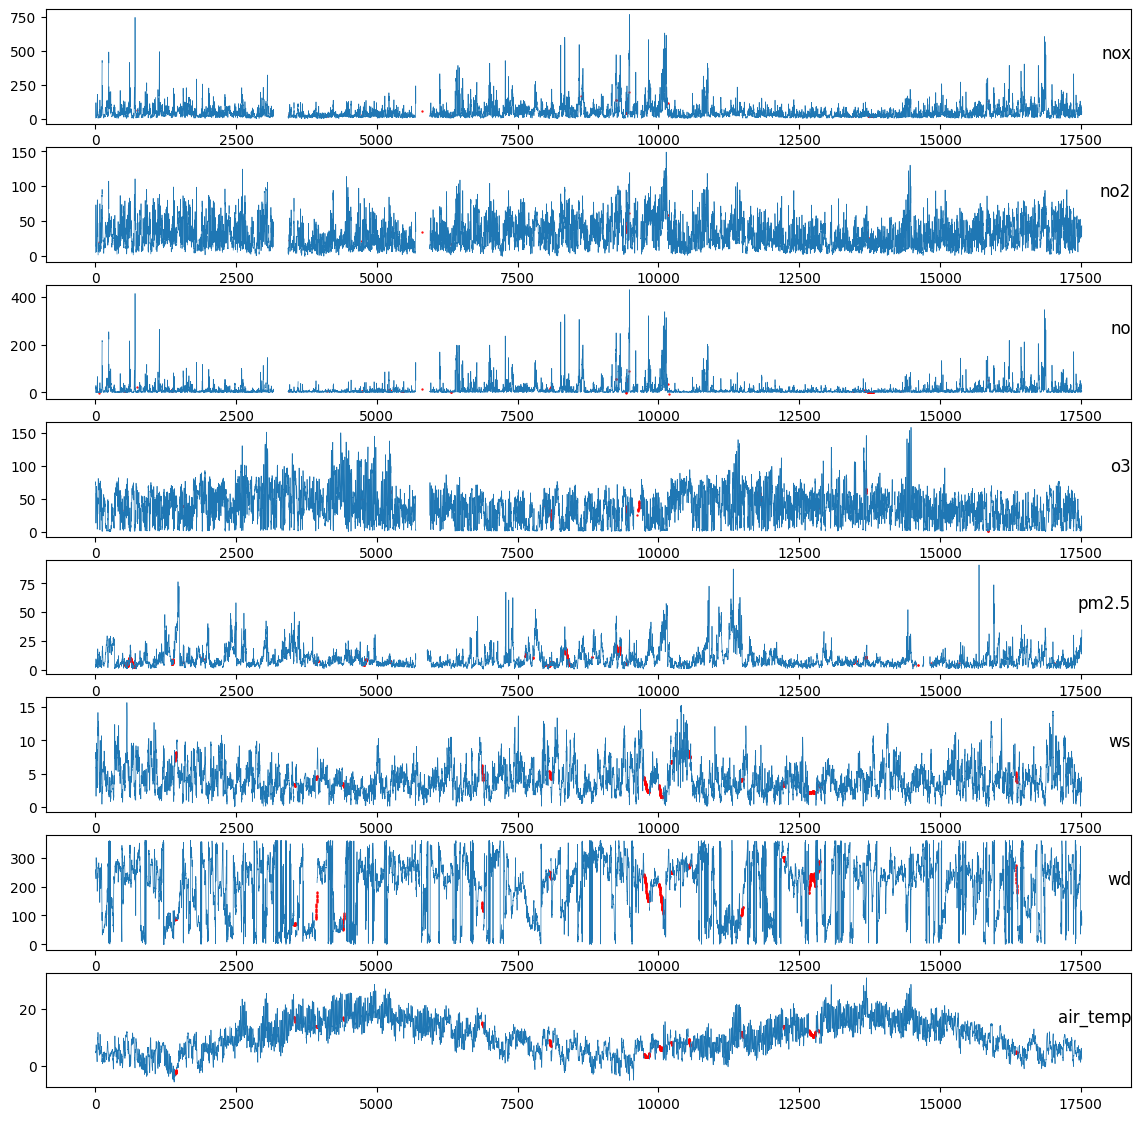

In [89]:
show_graph2('Harlington')
#The red dots represent our infill values. You can see that some of the infill values aren't very good. This is primarily due to the small number of samples used in the IDW algorithm, specifically the small number of monitoring stations. This is also due to the influence of significant noise. To reduce the impact of noise on subsequent training, we need to process the dataset using a filter.

Savgol filter to smoothen the data while preserving the peaks

In [17]:
from scipy.signal import savgol_filter

for i in sites_name:
    for j in air_pollutants_list:
        data=copy_dic[i].loc[:,j].values
        copy_dic[i].loc[:,j] = savgol_filter(data, 121, 3, mode= 'nearest')

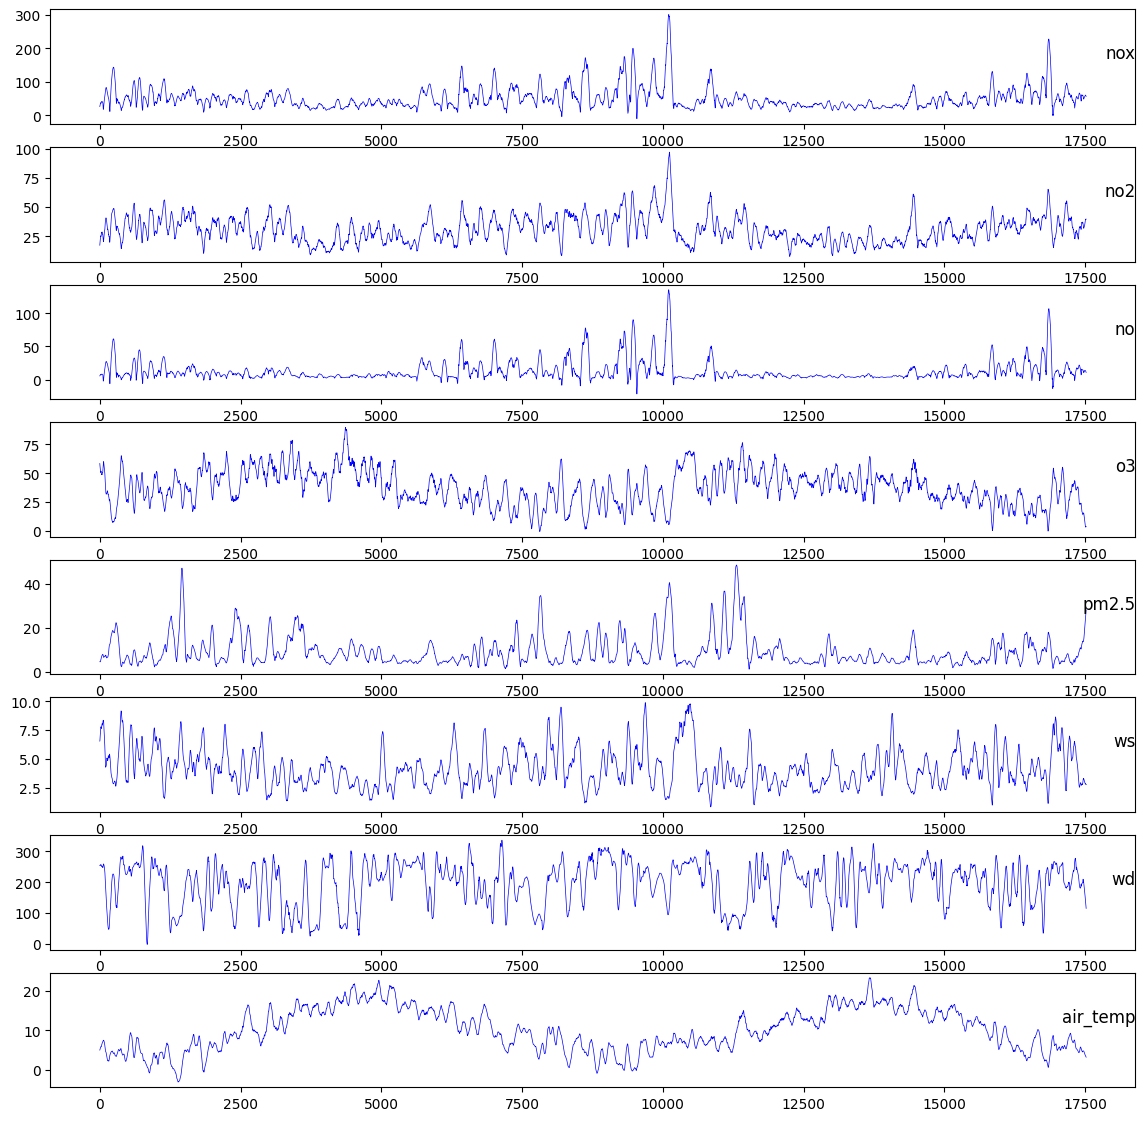

In [90]:
def show_graph3(site):
  dataset=sites_dic[site]
  dataset2=copy_dic[site]

  # plot each column
  pyplot.figure(figsize=(14,14))
  i=1
  for column in air_pollutants_list:
      pyplot.subplot(len(air_pollutants_list), 1, i)
      pyplot.plot(dataset2.loc[:, column].values,linewidth=0.5,color='b')
      pyplot.title(column, y=0.5, loc='right')
  #     pyplot.scatter(empty[i-1],dataset2.loc[empty[i-1], column].values,color='red',s=0.4)
      i += 1
  pyplot.show()

show_graph3('Harlington')

In [19]:
## Time series plots
import matplotlib.pyplot as plt
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas.testing as tm

def ts_plot(data):
    fig = plt.figure(figsize=(6, 7))
    gs = gridspec.GridSpec(2,2)
    """
    Generate TS, ACF, and PACF plots for all columns
    in all datasets stored in a dictionary.

    Parameters:
        datasets (dict): Dictionary of {name: DataFrame}
        lags (int): Number of lags for ACF/PACF
    """

    ax_ts = fig.add_subplot(gs[0, 0:2])
    ax_acf = fig.add_subplot(gs[1, 0])
    ax_pacf = fig.add_subplot(gs[1, 1])

    ax_ts.plot(range(len(data)), data)
    plot_acf(data, ax=ax_acf, lags=30)
    plot_pacf(data, ax=ax_pacf, lags=30)

    plt.show()

In [20]:
cols_to_keep = ['nox','no2','no','o3','pm2.5','ws','wd','air_temp']
for key in copy_dic:
    copy_dic[key] = copy_dic[key][cols_to_keep]


Dataset: Bloomsbury
Plotting nox ...


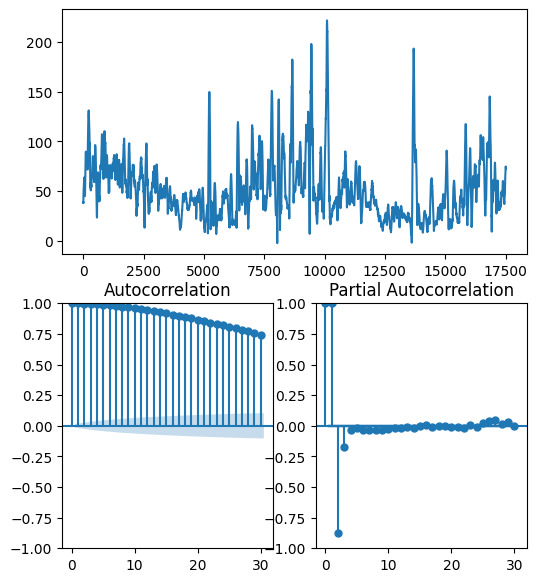

Plotting no2 ...


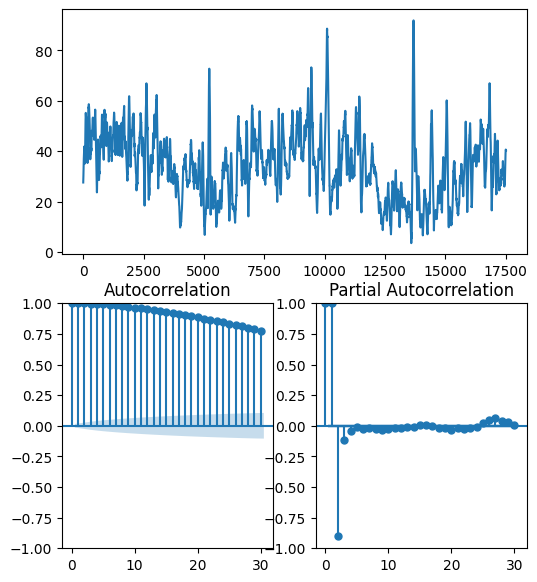

Plotting no ...


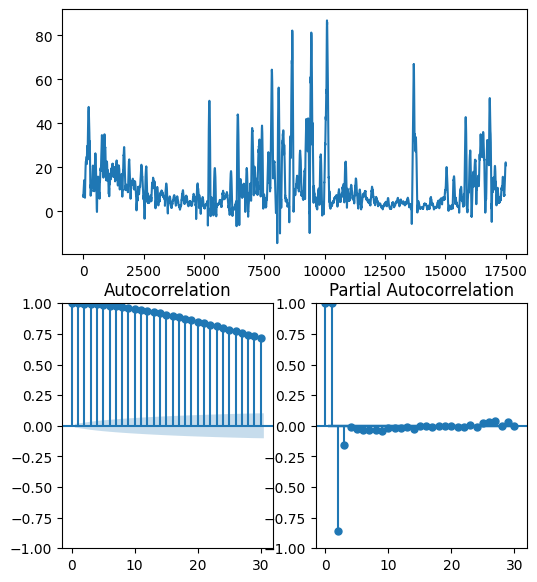

Plotting o3 ...


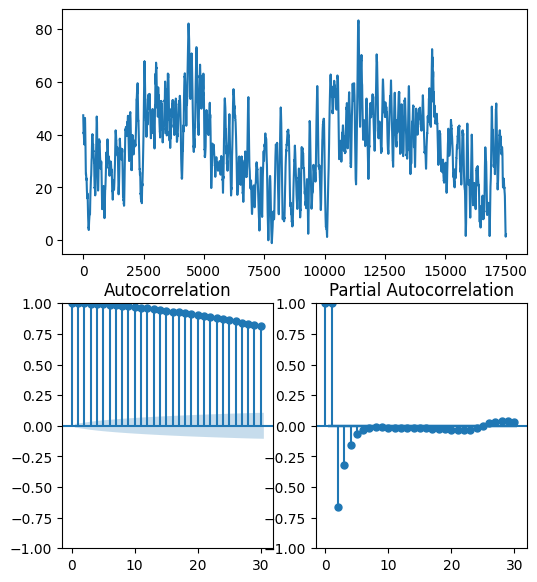

Plotting pm2.5 ...


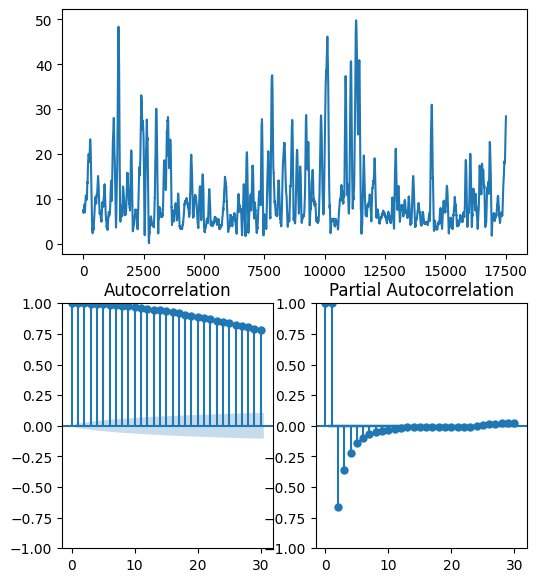

Plotting ws ...


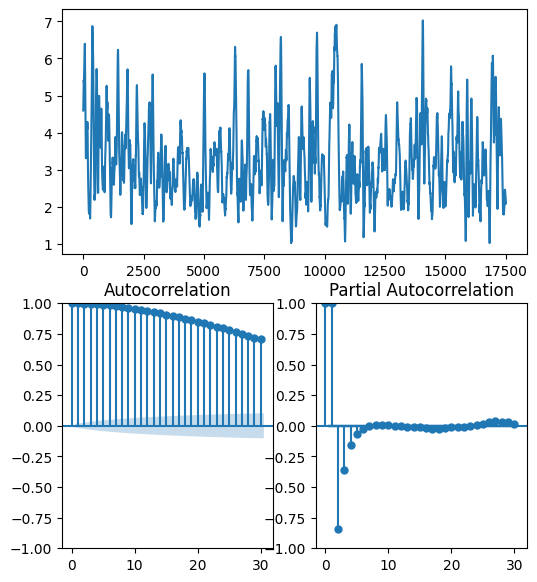

Plotting wd ...


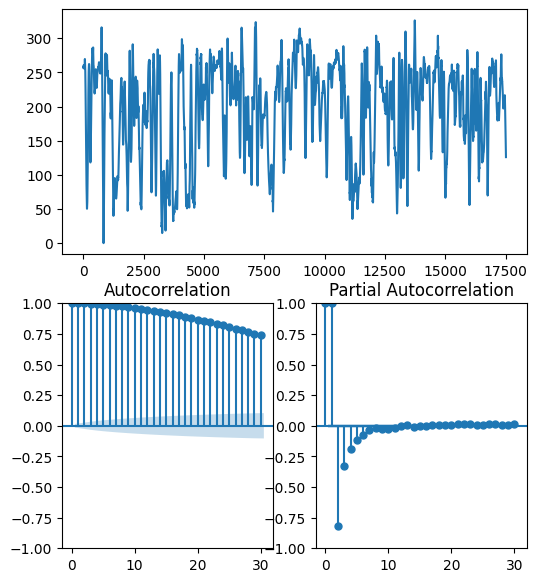

Plotting air_temp ...


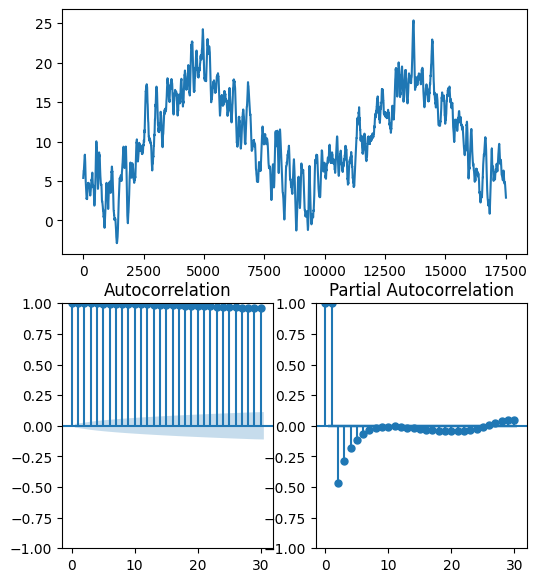


Dataset: Eltham
Plotting nox ...


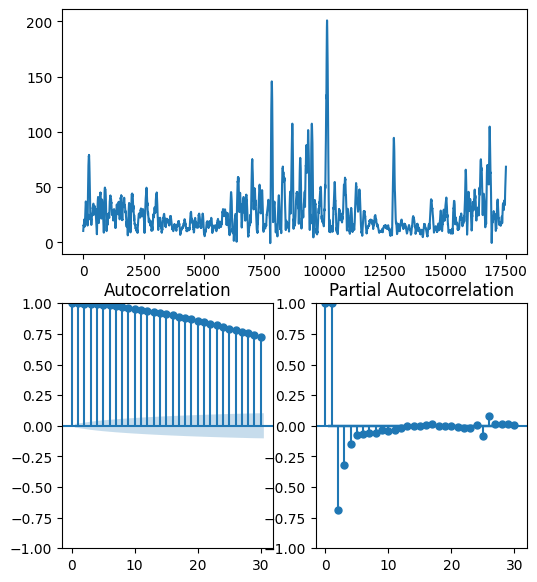

Plotting no2 ...


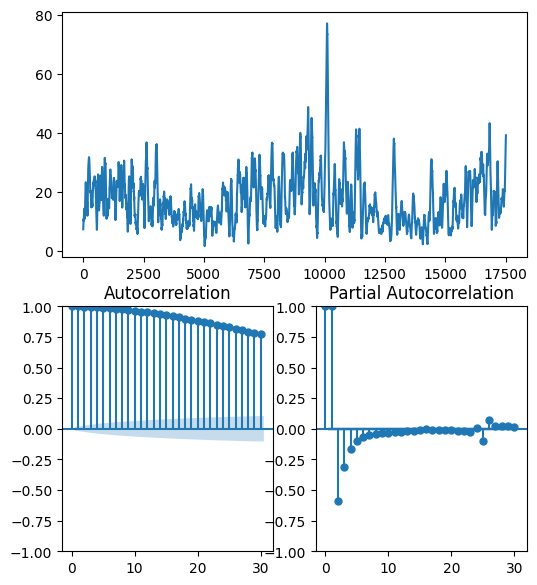

Plotting no ...


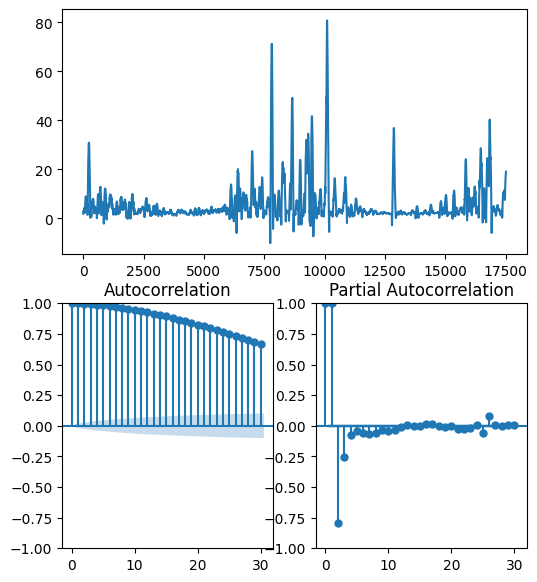

Plotting o3 ...


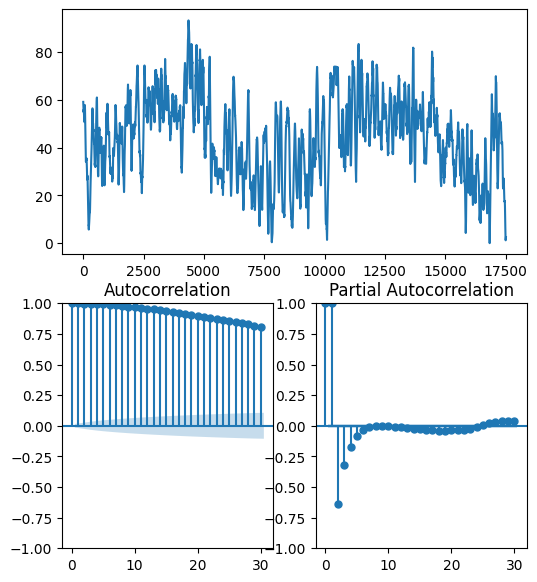

Plotting pm2.5 ...


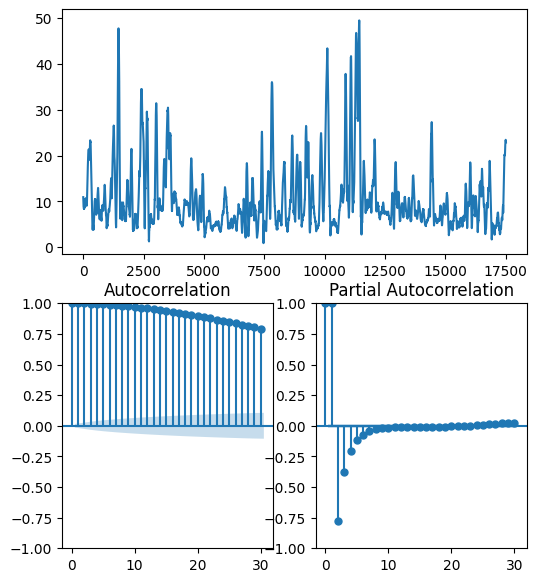

Plotting ws ...


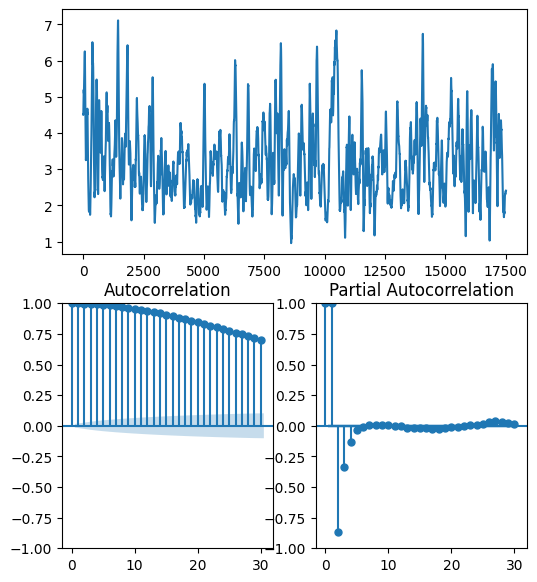

Plotting wd ...


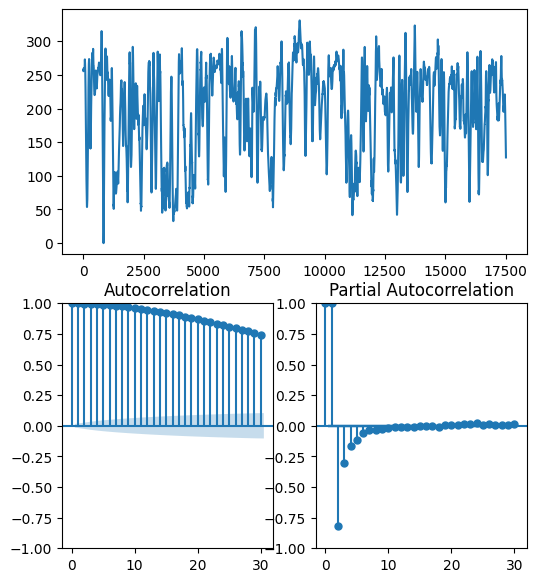

Plotting air_temp ...


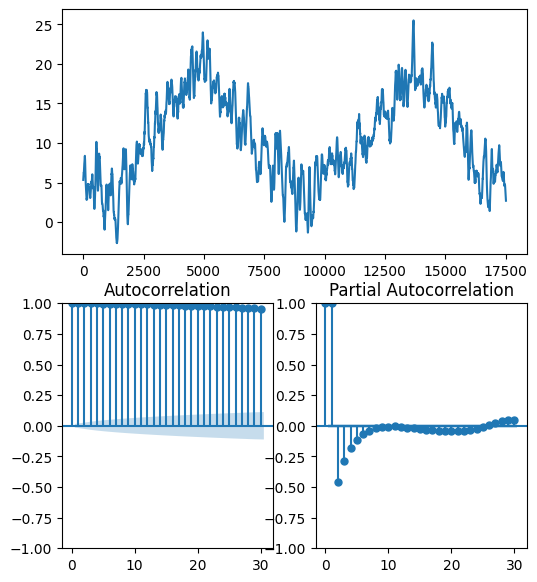


Dataset: Harlington
Plotting nox ...


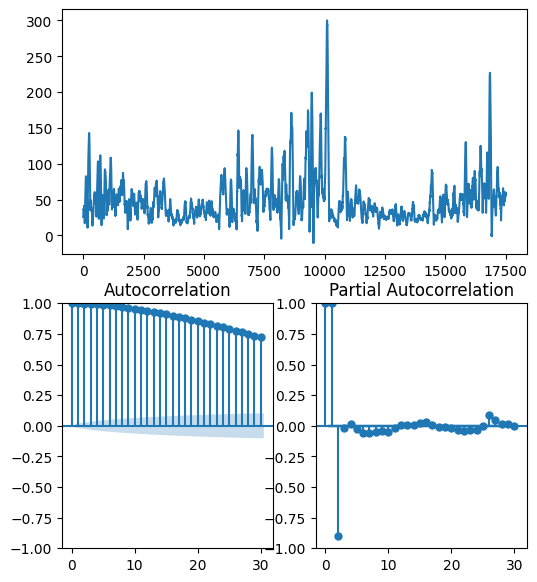

Plotting no2 ...


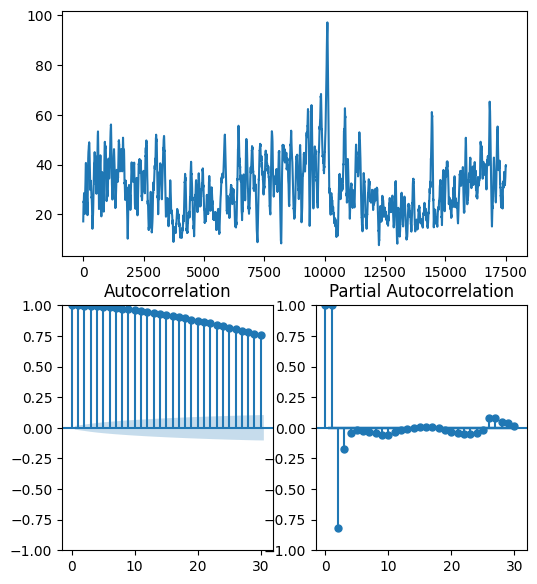

Plotting no ...


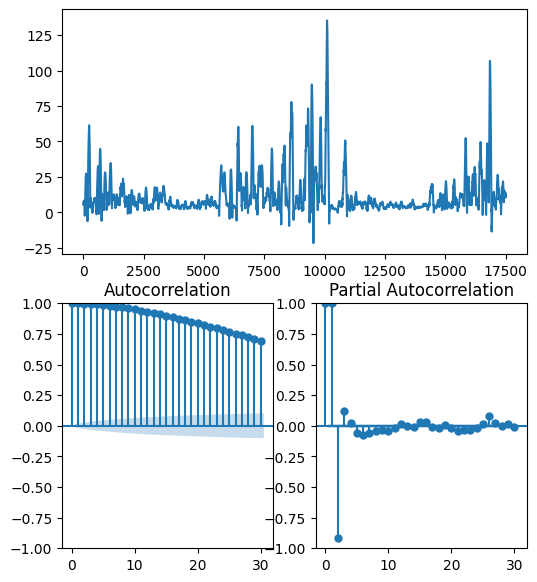

Plotting o3 ...


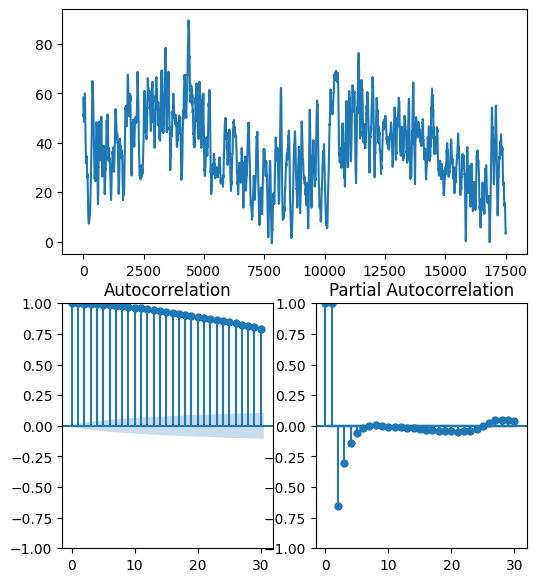

Plotting pm2.5 ...


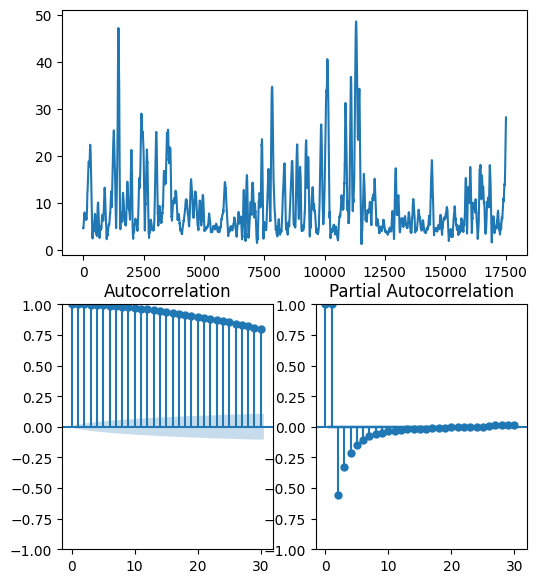

Plotting ws ...


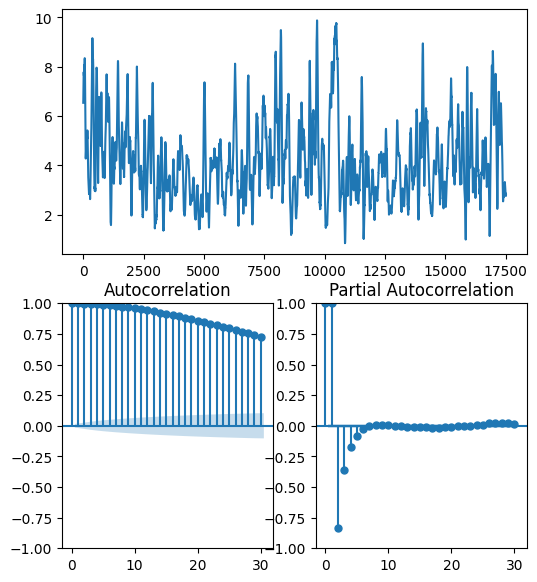

Plotting wd ...


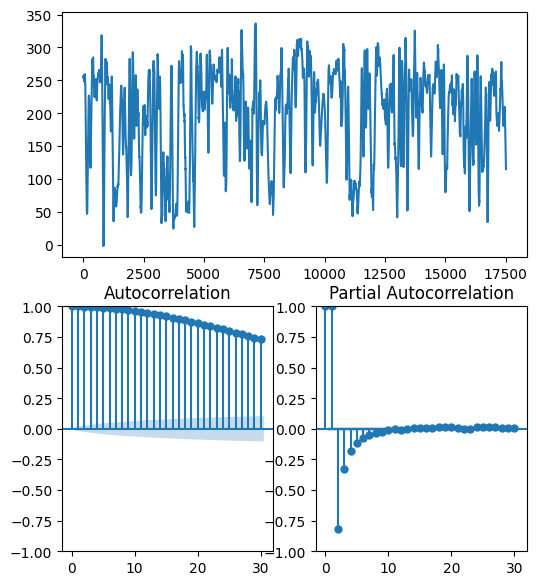

Plotting air_temp ...


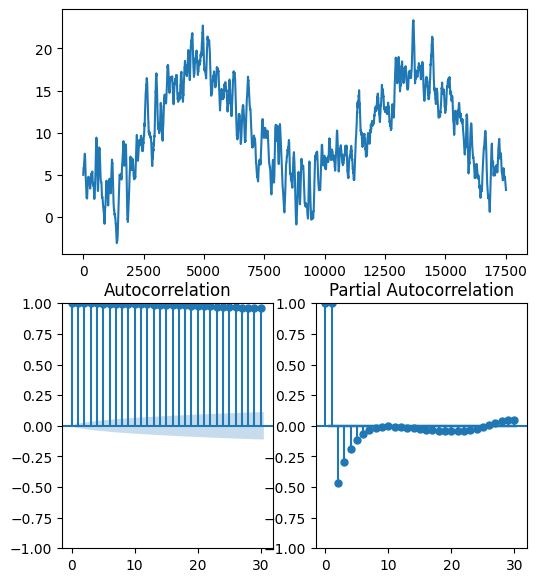


Dataset: Marylebone_Road
Plotting nox ...


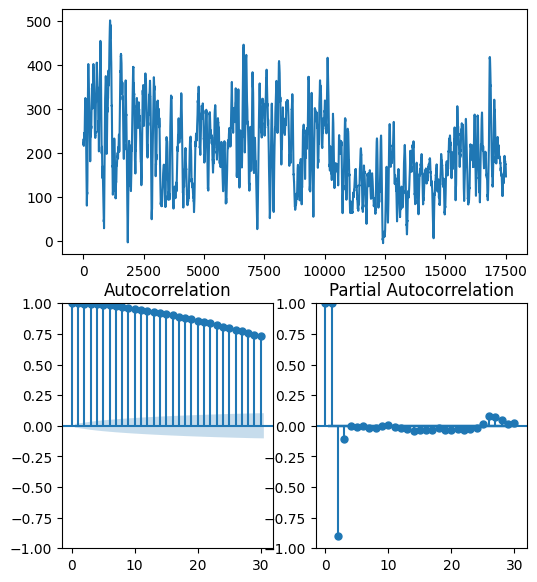

Plotting no2 ...


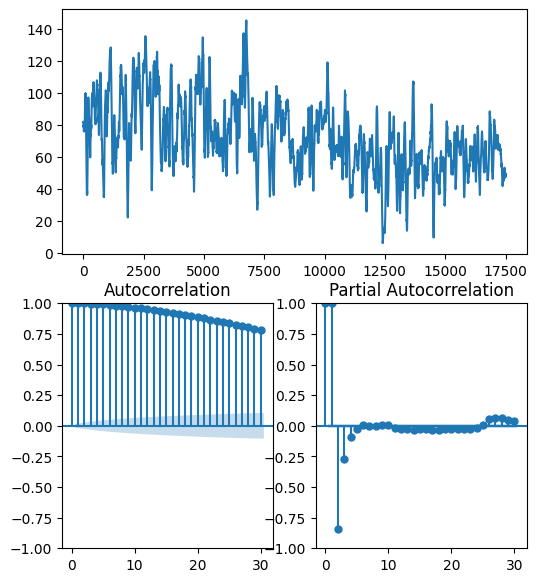

Plotting no ...


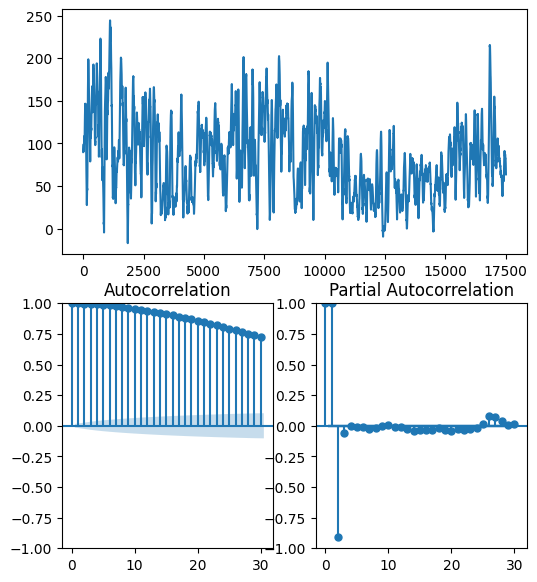

Plotting o3 ...


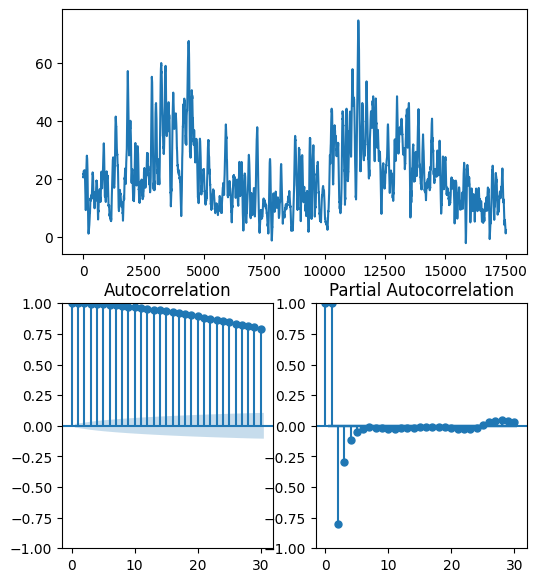

Plotting pm2.5 ...


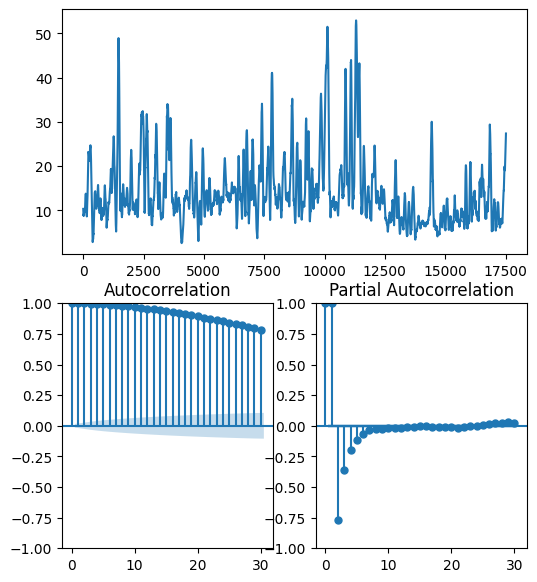

Plotting ws ...


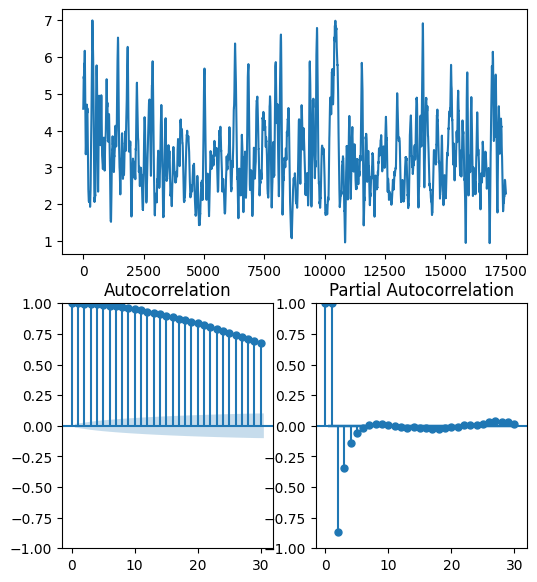

Plotting wd ...


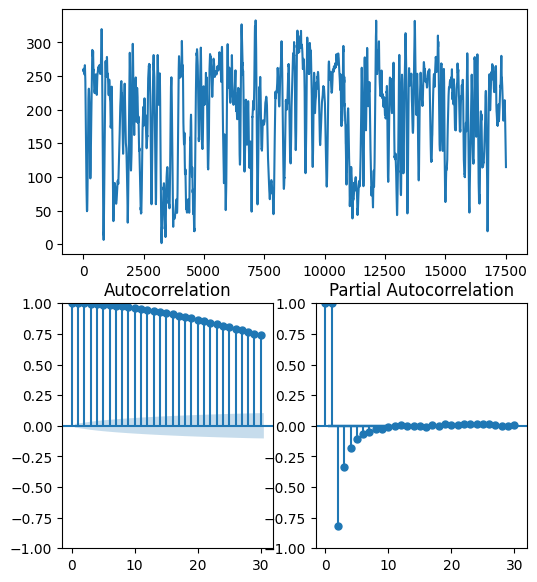

Plotting air_temp ...


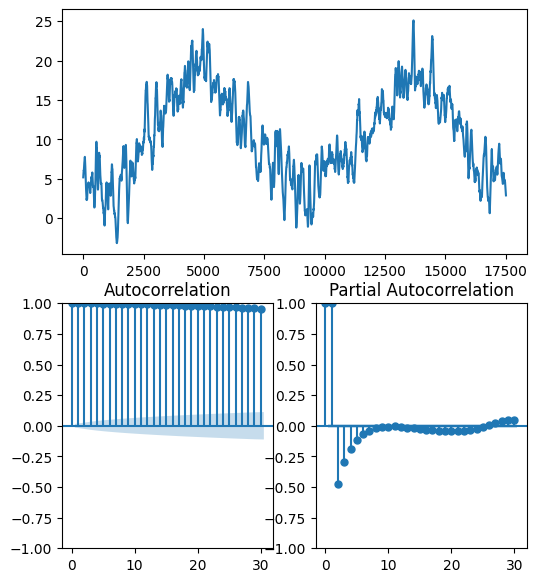


Dataset: N_Kensington
Plotting nox ...


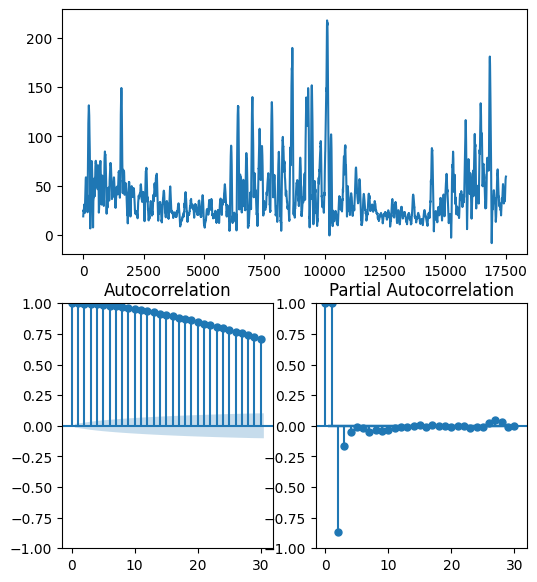

Plotting no2 ...


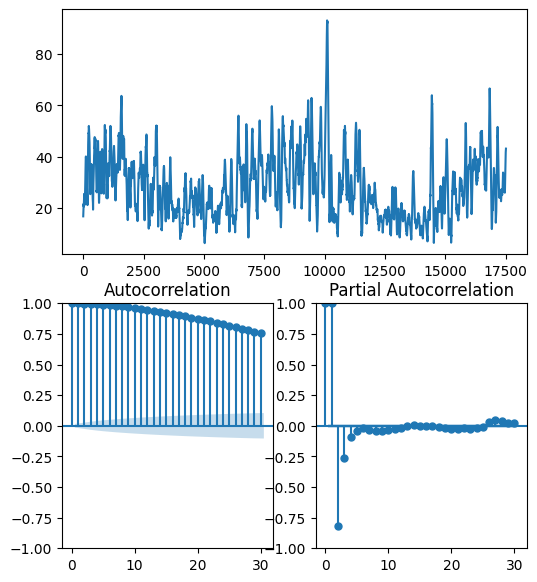

Plotting no ...


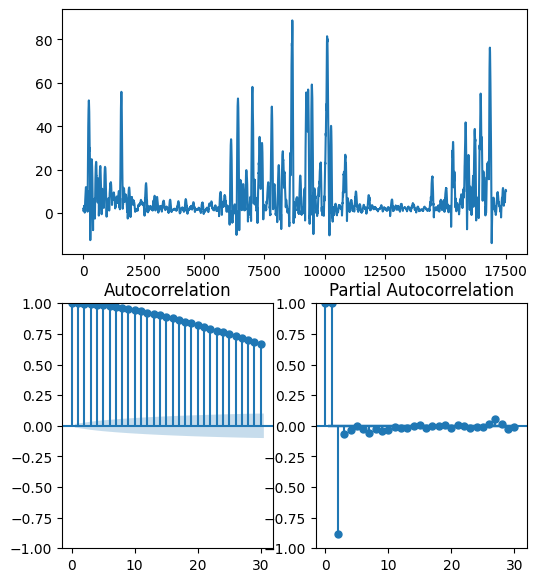

Plotting o3 ...


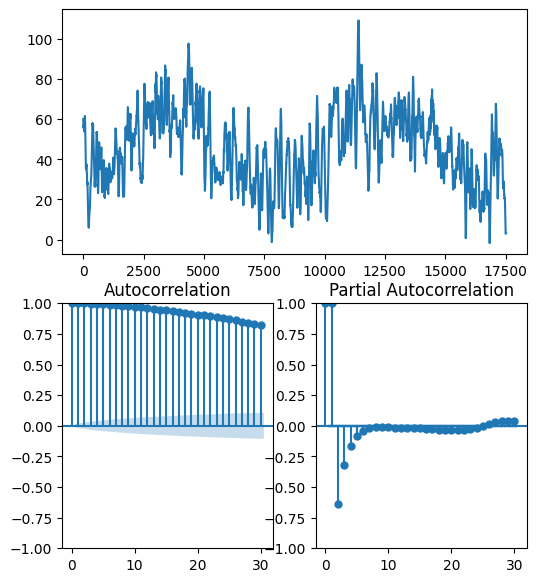

Plotting pm2.5 ...


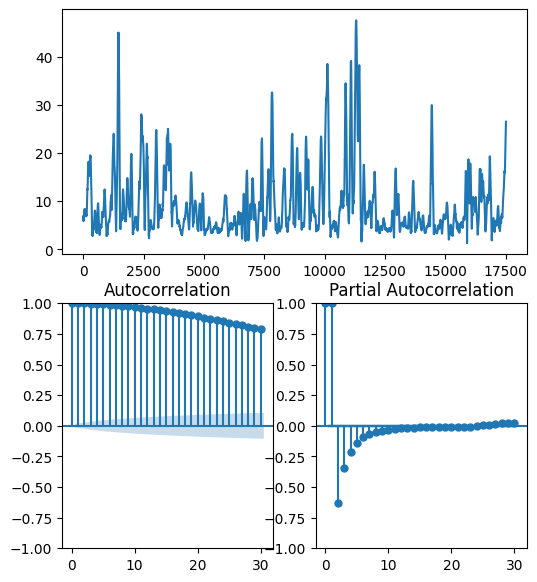

Plotting ws ...


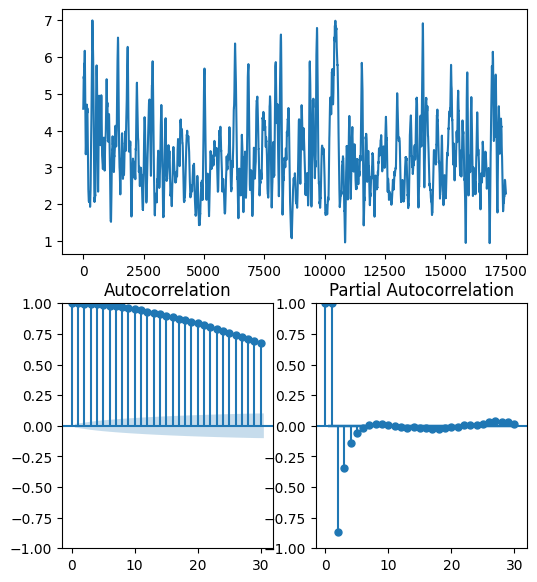

Plotting wd ...


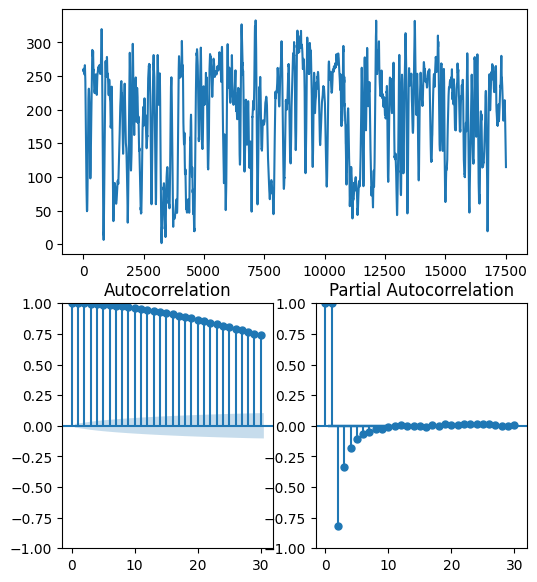

Plotting air_temp ...


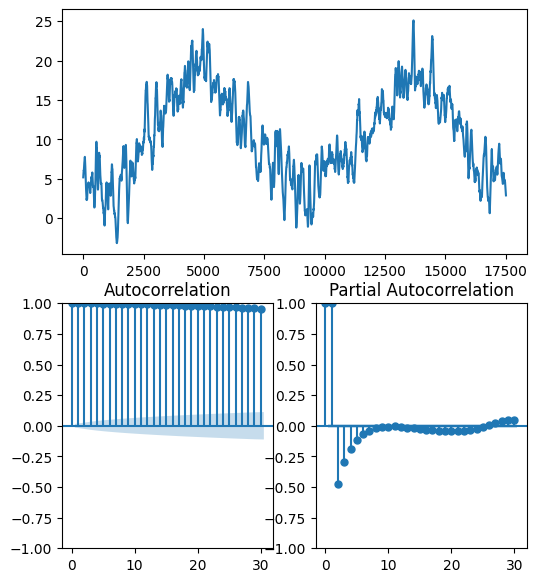

In [21]:
for name, df in copy_dic.items():
    print(f"\nDataset: {name}")
    for col in df.columns:
      print(f"Plotting {col} ...")
      ts_plot(df[col].values)


Dataset: Bloomsbury


nox       no2        no        o3     pm2.5        ws  \
nox       1.000000  0.906050  0.956502 -0.587820  0.534050 -0.345618   
no2       0.906050  1.000000  0.743189 -0.448181  0.571397 -0.389577   
no        0.956502  0.743189  1.000000 -0.620442  0.450458 -0.277797   
o3       -0.587820 -0.448181 -0.620442  1.000000 -0.251476  0.255761   
pm2.5     0.534050  0.571397  0.450458 -0.251476  1.000000 -0.406949   
ws       -0.345618 -0.389577 -0.277797  0.255761 -0.406949  1.000000   
wd       -0.129971 -0.196857 -0.069759  0.001539 -0.419617  0.289256   
air_temp -0.491521 -0.480732 -0.445724  0.550710 -0.217957 -0.049450   

                wd  air_temp  
nox      -0.129971 -0.491521  
no2      -0.196857 -0.480732  
no       -0.069759 -0.445724  
o3        0.001539  0.550710  
pm2.5    -0.419617 -0.217957  
ws        0.289256 -0.049450  
wd        1.000000  0.017982  
air_temp  0.017982  1.000000

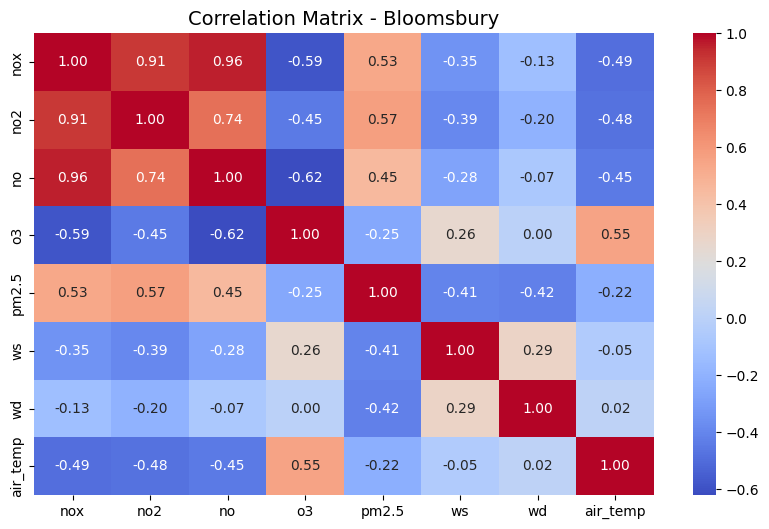


Dataset: Eltham


nox       no2        no        o3     pm2.5        ws  \
nox       1.000000  0.899020  0.951872 -0.594937  0.511965 -0.378501   
no2       0.899020  1.000000  0.721535 -0.553092  0.597514 -0.437159   
no        0.951872  0.721535  1.000000 -0.553551  0.391268 -0.292425   
o3       -0.594937 -0.553092 -0.553551  1.000000 -0.191926  0.302858   
pm2.5     0.511965  0.597514  0.391268 -0.191926  1.000000 -0.363286   
ws       -0.378501 -0.437159 -0.292425  0.302858 -0.363286  1.000000   
wd       -0.037713 -0.082250 -0.002031 -0.074251 -0.416429  0.246686   
air_temp -0.439658 -0.482627 -0.357335  0.460681 -0.169199 -0.075276   

                wd  air_temp  
nox      -0.037713 -0.439658  
no2      -0.082250 -0.482627  
no       -0.002031 -0.357335  
o3       -0.074251  0.460681  
pm2.5    -0.416429 -0.169199  
ws        0.246686 -0.075276  
wd        1.000000 -0.016400  
air_temp -0.016400  1.000000

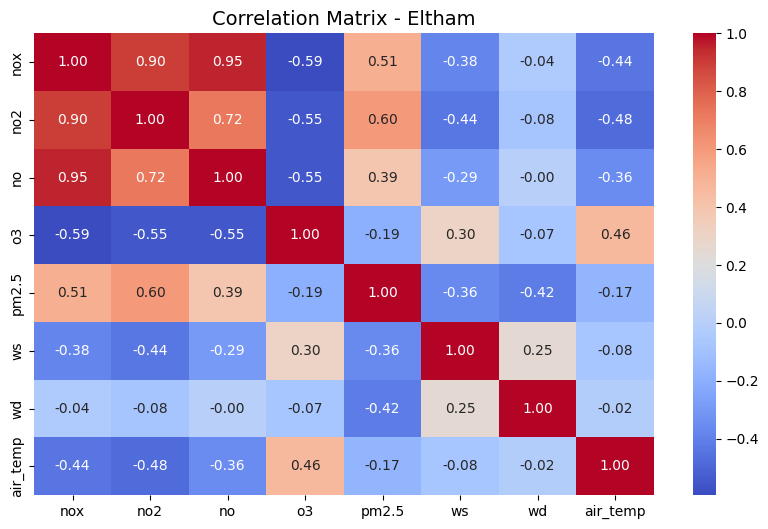


Dataset: Harlington


nox       no2        no        o3     pm2.5        ws  \
nox       1.000000  0.876715  0.972021 -0.596406  0.471689 -0.345672   
no2       0.876715  1.000000  0.739199 -0.514486  0.531304 -0.344721   
no        0.972021  0.739199  1.000000 -0.583817  0.400982 -0.315654   
o3       -0.596406 -0.514486 -0.583817  1.000000 -0.215102  0.264394   
pm2.5     0.471689  0.531304  0.400982 -0.215102  1.000000 -0.362239   
ws       -0.345672 -0.344721 -0.315654  0.264394 -0.362239  1.000000   
wd       -0.088724 -0.106008 -0.072460 -0.037777 -0.453005  0.238961   
air_temp -0.412320 -0.418704 -0.372843  0.379042 -0.204771 -0.203483   

                wd  air_temp  
nox      -0.088724 -0.412320  
no2      -0.106008 -0.418704  
no       -0.072460 -0.372843  
o3       -0.037777  0.379042  
pm2.5    -0.453005 -0.204771  
ws        0.238961 -0.203483  
wd        1.000000  0.044553  
air_temp  0.044553  1.000000

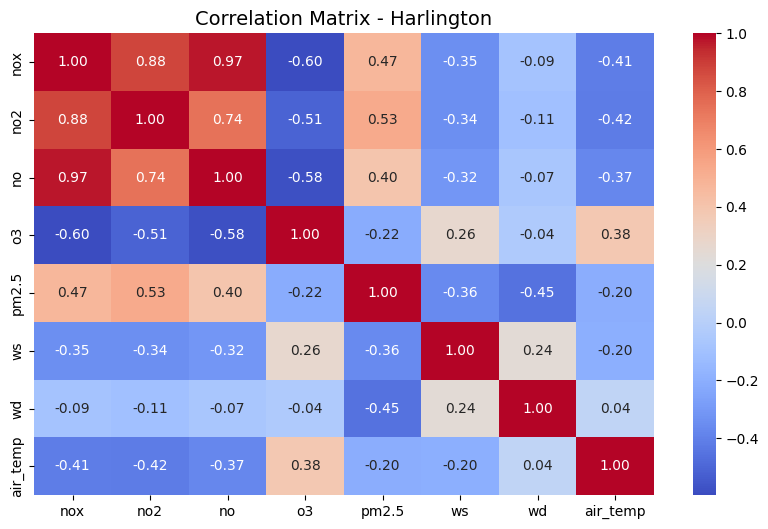


Dataset: Marylebone_Road


nox       no2        no        o3     pm2.5        ws  \
nox       1.000000  0.856355  0.985960 -0.636563  0.218141 -0.042907   
no2       0.856355  1.000000  0.758106 -0.332974  0.260516 -0.119595   
no        0.985960  0.758106  1.000000 -0.696227  0.191244 -0.015514   
o3       -0.636563 -0.332974 -0.696227  1.000000 -0.138074  0.136925   
pm2.5     0.218141  0.260516  0.191244 -0.138074  1.000000 -0.366109   
ws       -0.042907 -0.119595 -0.015514  0.136925 -0.366109  1.000000   
wd        0.341422  0.187165  0.370650 -0.379694 -0.298176  0.219211   
air_temp -0.186093  0.052110 -0.251863  0.287855 -0.173460 -0.096239   

                wd  air_temp  
nox       0.341422 -0.186093  
no2       0.187165  0.052110  
no        0.370650 -0.251863  
o3       -0.379694  0.287855  
pm2.5    -0.298176 -0.173460  
ws        0.219211 -0.096239  
wd        1.000000  0.018544  
air_temp  0.018544  1.000000

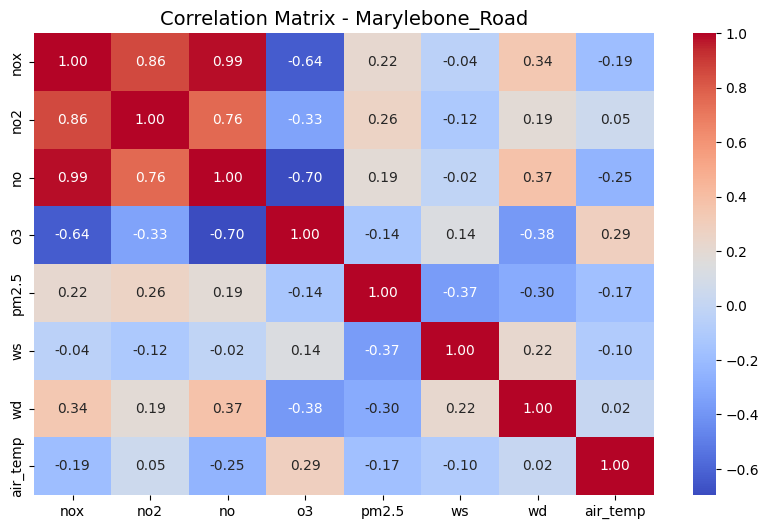


Dataset: N_Kensington


nox       no2        no        o3     pm2.5        ws  \
nox       1.000000  0.895133  0.957521 -0.604502  0.492017 -0.399774   
no2       0.895133  1.000000  0.728557 -0.559221  0.595929 -0.457276   
no        0.957521  0.728557  1.000000 -0.567108  0.370527 -0.318479   
o3       -0.604502 -0.559221 -0.567108  1.000000 -0.148381  0.246813   
pm2.5     0.492017  0.595929  0.370527 -0.148381  1.000000 -0.343652   
ws       -0.399774 -0.457276 -0.318479  0.246813 -0.343652  1.000000   
wd       -0.080975 -0.163311 -0.018784 -0.115428 -0.439010  0.219211   
air_temp -0.469703 -0.516833 -0.387404  0.508524 -0.210997 -0.096239   

                wd  air_temp  
nox      -0.080975 -0.469703  
no2      -0.163311 -0.516833  
no       -0.018784 -0.387404  
o3       -0.115428  0.508524  
pm2.5    -0.439010 -0.210997  
ws        0.219211 -0.096239  
wd        1.000000  0.018544  
air_temp  0.018544  1.000000

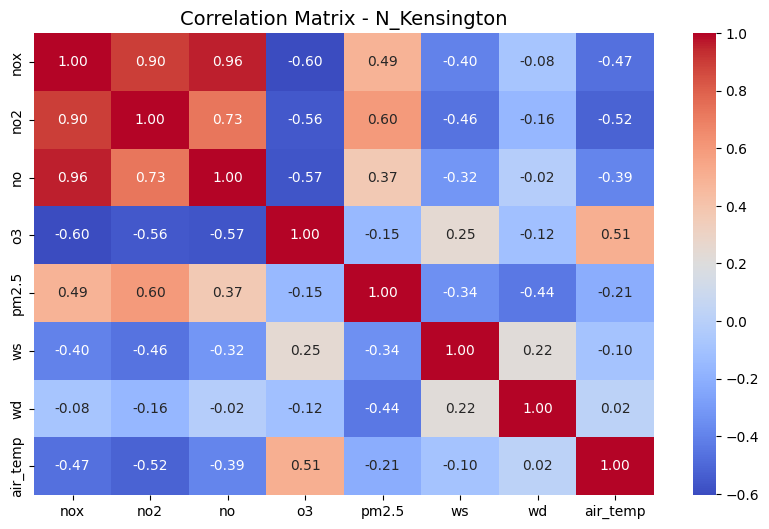

In [22]:
import seaborn as sns
for name, df in copy_dic.items():
    print(f"\nDataset: {name}")
    correlation_matrix = df.corr()
    display(correlation_matrix)
    #plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Correlation Matrix - {name}", fontsize=14)
    plt.show()

LSTM Model to predict Ozone and pm2.5 in the Harlington

In [91]:
dataset= copy_dic['Harlington']

In [92]:
dataset.head()

nox        no2        no         o3     pm2.5        ws          wd  \
0  25.652376  17.162654  5.536853  58.319162  4.669857  6.536290  254.682024   
1  26.603729  17.836684  5.717718  57.659575  4.672704  6.554847  254.312810   
2  27.500740  18.461178  5.895449  57.038377  4.669182  6.579388  254.014423   
3  28.379700  19.068324  6.072721  56.435795  4.654887  6.636912  253.861244   
4  29.266844  19.683219  6.250279  55.827704  4.636542  6.716429  253.903225   

   air_temp  
0  4.977652  
1  5.012679  
2  5.051040  
3  5.099631  
4  5.156423

In [93]:
var_origin=dataset[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']].values

In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(var_origin)

In [95]:
def splitData(var,per_val,per_test):
    num_val=int(len(var)*per_val)
    num_test=int(len(var)*per_test)
    train_size=int(len(var)-num_val-num_test)
    train_data=var[0:train_size]
    val_data=var[train_size:train_size+num_val]
    test_data=var[train_size+num_val:train_size+num_val+num_test]
    return train_data,val_data,test_data

In [96]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
var= torch.FloatTensor(scaled).to(device)

In [97]:
train_data,val_data,test_data=splitData(var,0.1,0.1)

In [98]:
print('The length of train data, validation data and test data are:',len(train_data),',',len(val_data),',',len(test_data))

The length of train data, validation data and test data are: 14016 , 1752 , 1752


In [99]:
train_window = 240
def create_train_sequence(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [100]:
train_inout_seq = create_train_sequence(train_data, train_window)
print('The total number of train windows is',len(train_inout_seq))

The total number of train windows is 13776


In [101]:
def create_val_sequence(train_data,val_data, tw):
    temp=torch.cat((train_data,val_data))
    inout_seq = []
    L = len(val_data)
    for i in range(L):
        val_seq = temp[-(train_window+L)+i:-L+i]
        val_label = test_data[i:i+1]
        inout_seq.append((val_seq ,val_label))

    return inout_seq

val_inout_seq = create_val_sequence(train_data, val_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


In [102]:
def create_test_sequence(train_data,val_data,test_data, tw):
    temp=torch.cat((train_data,val_data))
    temp=torch.cat((temp,test_data))
    inout_seq = []
    L = len(test_data)
    for i in range(L):
        test_seq = temp[-(train_window+L)+i:-L+i]
        test_label = test_data[i:i+1]
        inout_seq.append((test_seq ,test_label))

    return inout_seq

test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


In [103]:
train_data.shape

torch.Size([14016, 8])

In [104]:
from torch import nn
import torch.nn.init as init
import torch.nn.functional as F
class LSTM(nn.Module):
    def __init__(self,input_size=8,hidden_layer_size=50,output_size=1,num_layers=2):
        super().__init__()
        self.hidden_layer_size=hidden_layer_size
        self.lstm=nn.LSTM(input_size,hidden_layer_size,num_layers)
        self.linear1=nn.Linear(hidden_layer_size,hidden_layer_size)
        self.linear2=nn.Linear(hidden_layer_size,output_size)
        self.hidden_cell=(torch.zeros(num_layers,1,self.hidden_layer_size),torch.zeros(num_layers,1,self.hidden_layer_size))
        init_rnn(self.lstm,'xavier')

    def forward(self,input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq),1,8), self.hidden_cell)
        out=self.linear1(lstm_out.view(len(input_seq), -1))
        out=torch.tanh(out)
        predictions = self.linear2(out)
        return predictions[-1]

def init_rnn(x, type='uniform'):
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                if type == 'xavier':
                    init.xavier_normal_(getattr(x, w))
                elif type == 'uniform':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.uniform_(getattr(x, w), -stdv, stdv)
                elif type == 'normal':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.normal_(getattr(x, w), .0, stdv)
                else:
                    raise ValueError

In [ ]:
import copy

epochs=5

model_o3=LSTM().to(device)
model_pm25=LSTM().to(device)

loss_function=nn.MSELoss()
optimizer_o3 = torch.optim.SGD(model_o3.parameters(), lr=0.002,momentum=0.2, weight_decay=6e-4)
optimizer_pm25 = torch.optim.SGD(model_pm25.parameters(), lr=0.001,momentum=0.2, weight_decay=6e-4)

attr_dic={
    'o3':model_o3,
    'pm2.5':model_pm25
}

index_dic={
    'o3':0,
    'pm2.5':1

}

optimizer_dic={
    'o3':optimizer_o3,
    'pm2.5':optimizer_pm25
}

loss_train_dic={
    'o3':[],
    'pm2.5':[]
}

loss_val_dic={
    'o3':[],
    'pm2.5':[]
}

value_train_dic={
    'o3':[],
    'pm2.5':[]
}

value_val_dic={
    'o3':[],
    'pm2.5':[]
}


In [106]:
def train_model(attr,model):
  model.train()
  print('Training for:',attr)
  for i in range(epochs):
    #train
    add=0
    for seq,label in train_inout_seq:
        optimizer_dic[attr].zero_grad()
        seq=seq.to(device)
        label=label.to(device)
        model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size).to(device),torch.zeros(2, 1, model.hidden_layer_size).to(device))
        y_pred = model(seq)

        if(i==epochs-1):
          value_train_dic[attr].append(y_pred)

        single_loss = loss_function(y_pred[0], label[0,index_dic[attr]])
        add+=single_loss
        single_loss .backward()
        optimizer_dic[attr].step()
    loss_train=add/len(train_inout_seq)
    loss_train_dic[attr].append(loss_train)


    #val
    add=0
    t=0

    val_inputs=train_data[-train_window:]
    fut_pred = len(val_data)

    for seq,label in val_inout_seq:
      with torch.no_grad():
        seq = val_inputs[-train_window:].to(device)
        label=label.to(device)
        y_pred=model(seq)
        single_loss=loss_function(y_pred[0],label[0,index_dic[attr]])

        add+=single_loss

        if(i==epochs):
          value_val_dic[attr].append(y_pred)
        temp=copy.deepcopy(val_data[t])
        temp[index_dic[attr]]=y_pred
        temp=temp.view(1,-1)

        val_inputs=torch.cat((val_inputs,temp),0)
        t+=0

    loss_val=add/len(val_inout_seq)
    loss_val_dic[attr].append(loss_val)

    print(f'epoch: {i:3}  train_loss:{loss_train:10.8f} val_loss:{loss_val:10.8f}')
  print('----------------------')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def test_model(attr,model):
  temp=torch.cat((train_data,val_data))
  test_inputs=temp[-train_window:,:]

  fut_pred = len(test_data)
  test_list=[]
  test_results=copy.deepcopy(test_data)

  model.eval()

  for i in range(fut_pred):
      seq = test_inputs[-train_window:].to(device)
      with torch.no_grad():
          model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          y_pred=model(seq)
          temp=copy.deepcopy(test_data[i]).view(1,-1)
          test_inputs=torch.cat((test_inputs,temp),0)
          test_results[i]=y_pred

  actual_predictions = scaler.inverse_transform(np.array(test_results.cpu()))
  x = np.arange(len(train_data)+len(val_data), len(dataset), 1)
  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):,attr].values,color="red",label='real value')
  plt.plot(actual_predictions[:,index_dic[attr]],label='prediction')

  plt.title('hours vs '+attr)
  plt.ylabel(attr)
  plt.xlabel('hour')

  plt.legend(loc='upper right',fontsize=15)

  y_true=dataset.loc[len(dataset)-len(test_data):,attr].values
  y_pred=actual_predictions[:,index_dic[attr]]
  print('mse: ',mean_squared_error(y_true, y_pred))
  print('mae: ',mean_absolute_error(y_true, y_pred))

In [108]:
train_model('o3', model_o3)

Training for: o3
epoch:   0  train_loss:0.03984387 val_loss:0.21975112
epoch:   1  train_loss:0.00704021 val_loss:0.18363200
epoch:   2  train_loss:0.00295803 val_loss:0.17976929
epoch:   3  train_loss:0.00221573 val_loss:0.17658719
epoch:   4  train_loss:0.00193095 val_loss:0.17410107
----------------------


mse:  17.877380454151577
mae:  3.459631085382524


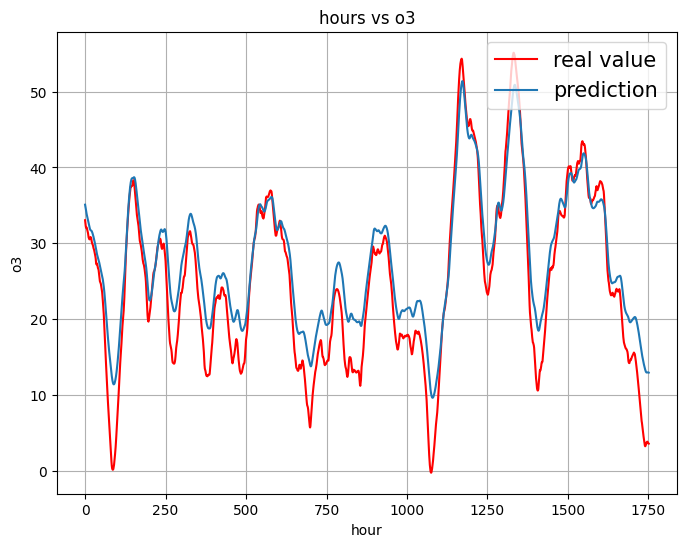

In [109]:
test_model('o3',model_o3)

In [110]:
train_model('pm2.5',model_pm25)

Training for: pm2.5
epoch:   0  train_loss:0.05233302 val_loss:0.05614293
epoch:   1  train_loss:0.01174144 val_loss:0.05860044
epoch:   2  train_loss:0.00439783 val_loss:0.06164634
epoch:   3  train_loss:0.00240437 val_loss:0.06420852
epoch:   4  train_loss:0.00179697 val_loss:0.06595314
----------------------


mse:  2.760370553480912
mae:  1.3989714844412948


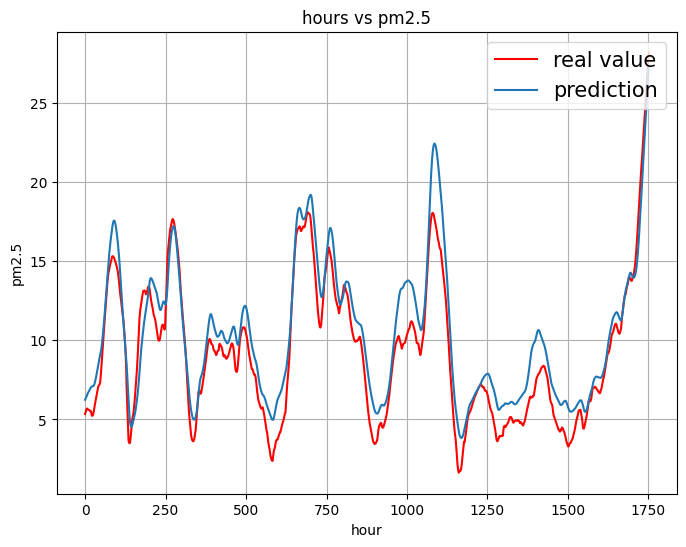

In [111]:
test_model('pm2.5',model_pm25)

In [114]:
def predict_future(attr,model):
  temp=torch.cat((train_data,val_data))
  test_inputs=temp[-train_window:,:]

  fut_pred = 96
  test_list=[]
  test_results=copy.deepcopy(test_data)

  model.eval()

  for i in range(fut_pred):
      seq = test_inputs[-train_window:].to(device)
      with torch.no_grad():
          model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          y_pred=model(seq)
          temp=copy.deepcopy(test_data[i])
          temp[index_dic[attr]]=y_pred
          temp=temp.view(1,-1)
          test_inputs=torch.cat((test_inputs,temp),0)
          test_results[i]=y_pred

  actual_predictions = scaler.inverse_transform(np.array(test_results.cpu()))

  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred,attr].values,color="red",label='real value')
  plt.plot(actual_predictions[:fut_pred,index_dic[attr]],label='prediction')

  plt.title('hours vs '+attr)
  plt.ylabel(attr)
  plt.xlabel('hour')

  plt.legend(loc='upper right',fontsize=15)

  y_true=dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred-1,attr].values
  y_pred=actual_predictions[:fut_pred,index_dic[attr]]

  print('mse: ',mean_squared_error(y_true, y_pred))
  print('mae: ',mean_absolute_error(y_true, y_pred))

  y_pred=pd.DataFrame(y_pred)

mse:  168.9545916266594
mae:  10.532560311601367


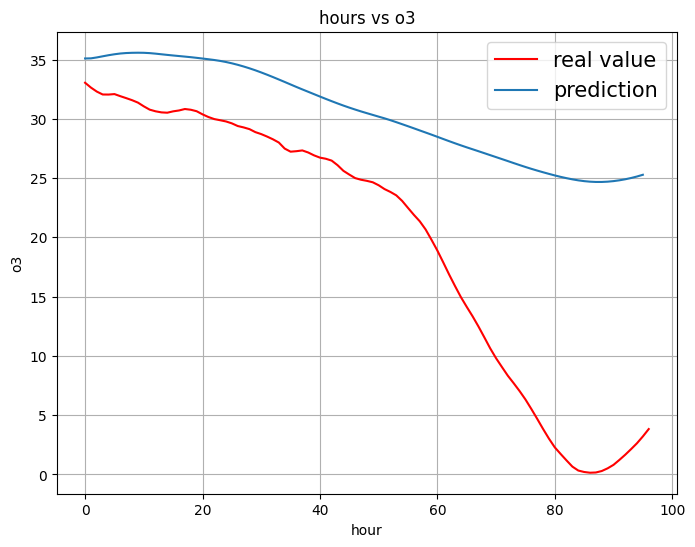

In [115]:
predict_future('o3',model_o3)

mse:  21.180634257034857
mae:  4.232300896192604


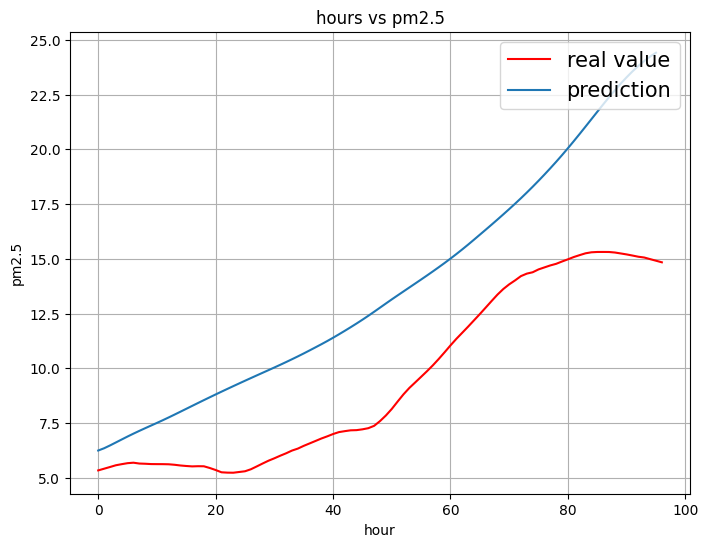

In [116]:
predict_future('pm2.5',model_pm25)